<a href="https://colab.research.google.com/github/NicholasLeotta99/Neuromatch_BrainCancer/blob/Nick/code/VGG19_Classifier_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Package Imports
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.utils import make_grid
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset
import torchvision.models as models
from torchsummary import summary

import os
from google.colab import files
from PIL import Image
import subprocess

import random
random.seed(2023)


In [2]:
# @title Data Loading
print('Upload kaggle.json account information to download the dataset:')
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip -q brain-tumor-mri-dataset.zip

Upload kaggle.json account information to download the dataset:


Saving kaggle.json to kaggle.json
 99% 147M/149M [00:07<00:00, 24.1MB/s]
100% 149M/149M [00:07<00:00, 19.6MB/s]


In [3]:
# @title Subsampling Validation Data

if not os.path.isdir('./Validation/'):
  os.mkdir('./Validation/')
  classes = os.listdir('./Training/')
  training_samples = []
  for i in classes:
    os.mkdir(f'./Validation/{i}/')
    files = os.listdir(f'./Training/{i}/')
    for f in files:
      training_samples.append(f'/{i}/{f}')
  random.shuffle(training_samples)
  validation_samples = training_samples[0:1100]
  training_samples = training_samples[1100:]
  for samp in validation_samples:
    os.rename(f'./Training{samp}', f'./Validation{samp}')


In [4]:
# @title Loading Model
Classifier = models.vgg19(weights='DEFAULT')
#Replace the classifying linear network with one with custom number of output classes
num_features = Classifier.classifier[-1].in_features
Classifier.classifier[-1] = nn.Linear(num_features, 4)
Classifier.to('cuda')
summary(Classifier, (3, 256, 256))

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 160MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

0 tensor([0, 3, 0, 2, 1, 1, 3, 3, 3, 0, 1, 2, 3, 2, 1, 3, 3, 1, 3, 0, 0, 2, 1, 0,
        2, 0, 1, 0, 2, 2, 1, 1])


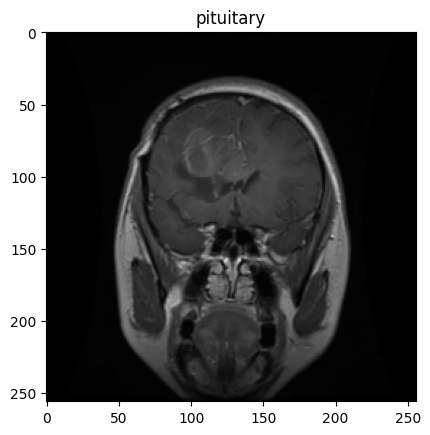

In [45]:
# @title Dataset Generation
#TODO - Verify labels correspond to classes
data_transf = transforms.Compose([
transforms.Resize((256, 256)),
transforms.ToTensor()])

TrainingDataset = ImageFolder(root='./Training/', transform=data_transf)#, transform=torchvision.models.VGG19_Weights.IMAGENET1K_V1.transforms)
TrainingLoader = DataLoader(TrainingDataset, batch_size=32, shuffle=True)

ValidationDataset = ImageFolder(root='./Validation/', transform=data_transf)#, transform=torchvision.models.VGG19_Weights.IMAGENET1K_V1.transforms)
ValidationLoader = DataLoader(ValidationDataset, batch_size=32, shuffle=True)

for batch_number , (images, labels) in enumerate(TrainingLoader):
  print(batch_number, labels)
  plt.imshow(torch.moveaxis(images[0], 0, -1))
  plt.title(classes[labels[0]])
  plt.show()
  break

In [46]:
# Cross Entropy Loss for categorization
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(Classifier.parameters(), lr=0.005, momentum=.5)


def calc_accuracy(prediction, label):
  prediction = torch.argmax(prediction, axis=1)
  return (prediction == label).sum()/len(label) * 100


def one_epoch(epoch_index):
  current_loss = 0
  running_loss = 0
  acc = []
  val_acc = []

  for i, data in enumerate(TrainingLoader):
    inputs, labels = data

    inputs = inputs.to('cuda')
    labels = labels.to('cuda')

    optimizer.zero_grad()
    outputs = Classifier(inputs)
    acc.append(calc_accuracy(outputs, labels))
    loss = loss_fn(outputs, labels)
    loss.backward()

    optimizer.step()

    current_loss += loss.item()
    running_loss += loss.item()
    if i % 10 == 9:
      print(f'Epoch {epoch_index + 1}, Batch {i + 1}, Loss: {current_loss / 10:.3f}, Running Accuracy {sum(acc)/(i+1)}')
      current_loss = 0.0

  print(f'Epoch {epoch_index + 1}, Total Loss: {running_loss}, Total Accuracy: {sum(acc)/(i+1)}')
  running_loss = 0
  print('Validating...')
  for i, data in enumerate(ValidationLoader):
    inputs, labels = data
    inputs = inputs.to('cuda')
    labels = labels.to('cuda')
    outputs = Classifier(inputs)
    val_acc.append(calc_accuracy(outputs, labels))
    loss = loss_fn(outputs, labels)
    running_loss += loss.item()
  print(f'Epoch{epoch_index + 1}, Validation Loss: {running_loss}, Validation Accuracy {sum(val_acc)/(i+1)}')

In [47]:
for i in range(0,100):
  one_epoch(i)



OutOfMemoryError: ignored